# Intent Detection: Identify user intent efficiently with a custom classifier

In this cookbook, we will explore classification for intent detection and classification using our Classifier Factory.

To keep things straightforward, we will concentrate on a particular example that involves single-target classification.

## Dataset
We will use a subset of the [mteb/amazon_massive_intent](https://huggingface.co/datasets/mteb/amazon_massive_intent) dataset. This subset includes an intent for different user requests.

### Subset
Let's download and prepare the subset. We will install the `datasets` library and load the dataset.

In [ ]:
%%capture
!pip install datasets

In [ ]:
# @title Loading and preparing subset
%%capture
# Import necessary libraries
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the entire amazon_massive_intent dataset
dataset = load_dataset("mteb/amazon_massive_intent")

# Filter for English language samples
train_samples = dataset["train"].filter(lambda x: x["lang"] == "en")

# Select only the required columns
train_samples = train_samples.select_columns(["text", "label_text"])

# Convert to pandas DataFrame
train_df = pd.DataFrame(train_samples)

# Function to remove labels with less than 200 samples and limit each label to 600 samples
def process_labels(df, min_samples=200, max_samples=600):
    label_counts = df["label_text"].value_counts()
    labels_to_keep = label_counts[label_counts >= min_samples].index
    df = df[df["label_text"].isin(labels_to_keep)]

    # Limit each label to max_samples
    balanced_df = pd.DataFrame()
    for label in labels_to_keep:
        label_samples = df[df["label_text"] == label].sample(
            n=min(len(df[df["label_text"] == label]), max_samples), random_state=42
        )
        balanced_df = pd.concat([balanced_df, label_samples])

    return balanced_df

# Process labels in the training dataset
train_df = process_labels(train_df)

# Split the training data into train, validation, and test sets
train_df, temp_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["label_text"]
)
validation_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_text"]
)

In [ ]:
# Display the test DataFrame to verify
test_df

,text,label_text
888,what's the weather forecast for today,weather_query
11290,send the email to this new email address,email_sendemail
6194,hey please provide information about events by...,calendar_query
5663,schedule my meeting with mr. john hopkins tomo...,calendar_set
2496,please play some lady gaga,play_music
...,...,...
3674,do i need to take an umbrella today,weather_query
4610,what are all the upcoming events,calendar_query
2646,let's listen to a playlist,play_music
4493,hey i just lost my wallet today,general_quirky


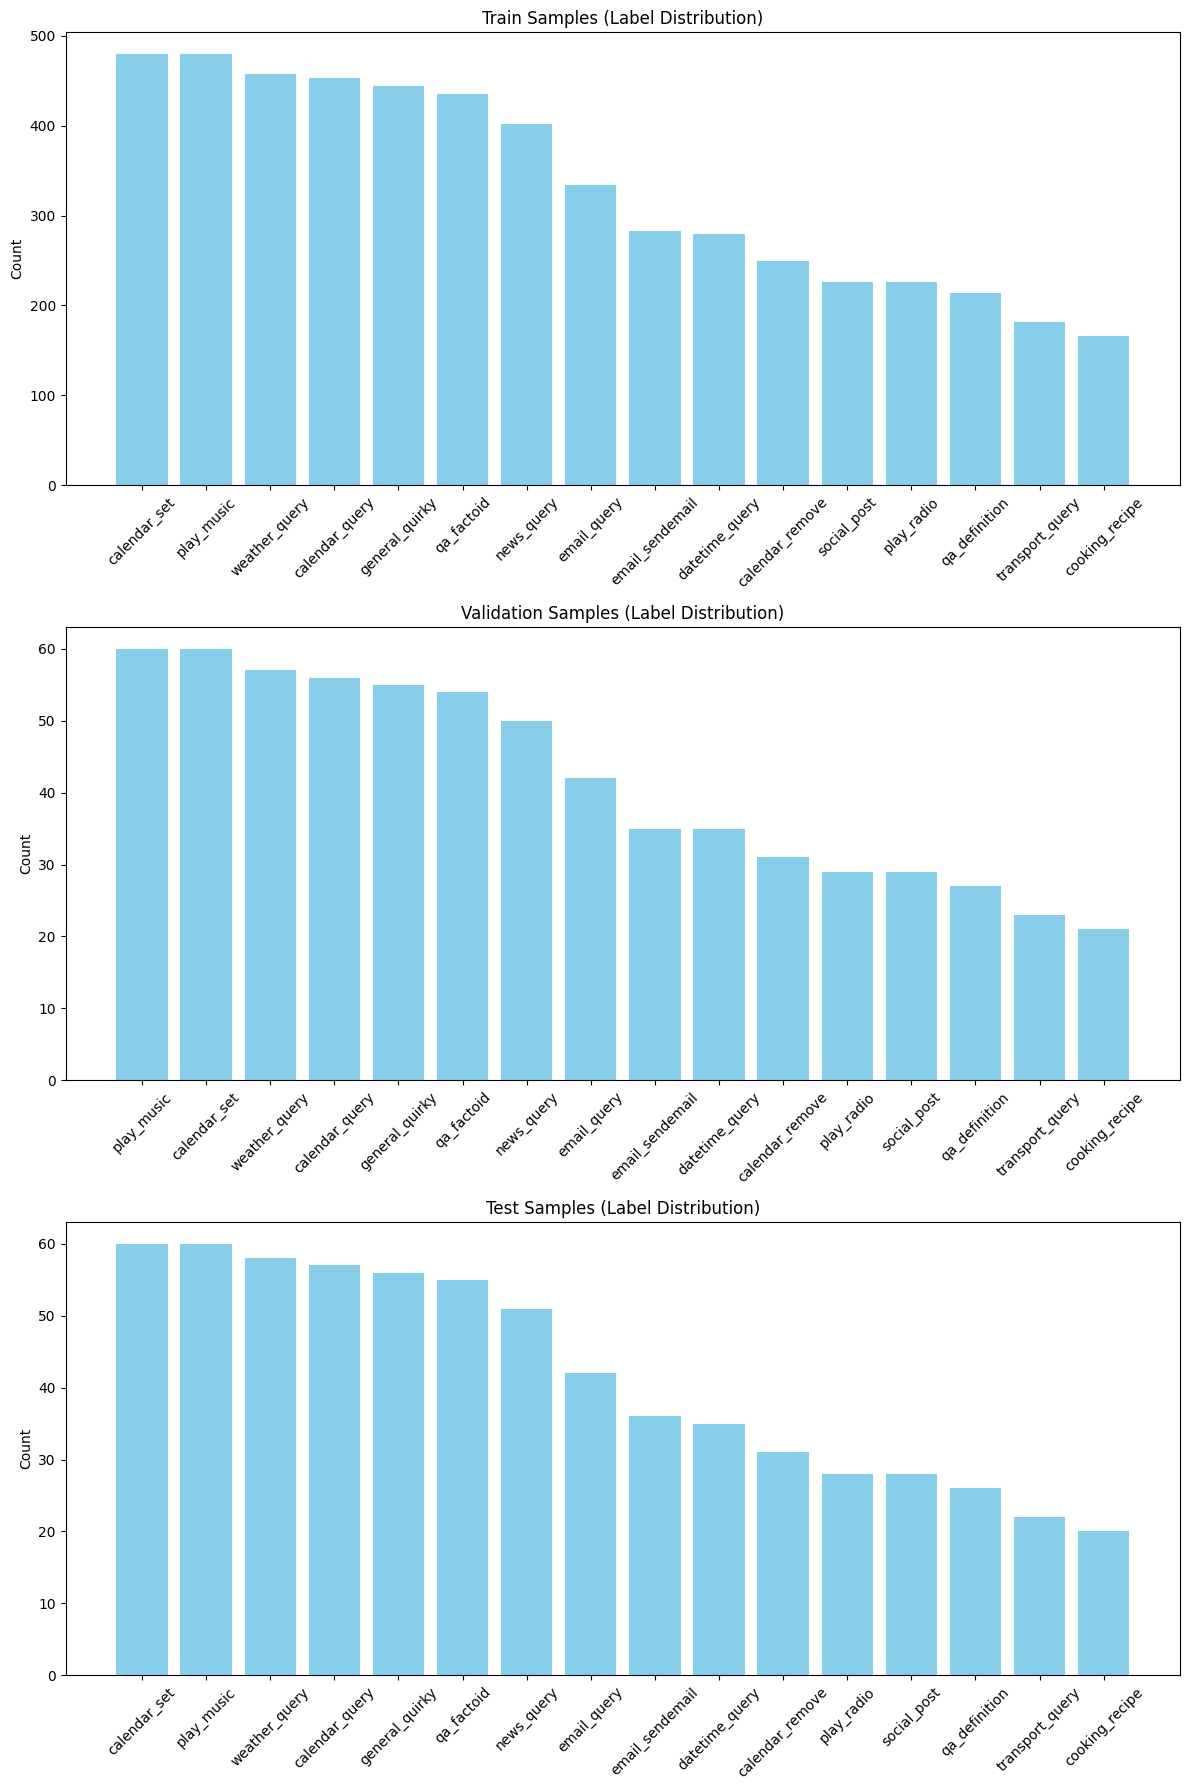

In [ ]:
# @title Data distribution
import matplotlib.pyplot as plt
from collections import Counter

# Function to count the number of samples for each label
def count_labels(samples):
    labels = [sample["label_text"] for sample in samples.to_dict("records")]
    return Counter(labels)

# Count labels for each dataset
train_label_counts = count_labels(train_df)
validation_label_counts = count_labels(validation_df)
test_label_counts = count_labels(test_df)

# Create a single figure with subplots for bar charts
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot the bar charts for label distribution
def plot_label_distribution(ax, label_counts, title):
    # Sort labels by count in descending order
    sorted_labels, sorted_counts = zip(
        *sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    )
    ax.bar(sorted_labels, sorted_counts, color="skyblue")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)

# Plot label distribution for each dataset
plot_label_distribution(
    axes[0], train_label_counts, "Train Samples (Label Distribution)"
)
plot_label_distribution(
    axes[1], validation_label_counts, "Validation Samples (Label Distribution)"
)
plot_label_distribution(axes[2], test_label_counts, "Test Samples (Label Distribution)")

plt.tight_layout()
plt.show()

## Format Data

Now that we have loaded our dataset, we will convert it to the proper desired format to upload for training.

The data will be converted to a **JSONL** format as follows:
```json
{"text": "place a birthday party with ale ross and amy in my calendar", "labels": {"intent": "calendar_set"}}
{"text": "new music tracks", "labels": {"intent": "play_music"}}
{"text": "get me the details of upcoming oscar two thousand and seventeen", "labels": {"intent": "calendar_query"}}
{"text": "is there any event today in my calendar", "labels": {"intent": "calendar_query"}}
{"text": "send email to mommy that i'll be going the party", "labels": {"intent": "email_sendemail"}}
...
```
With an example of a label being:
```json
"labels": {
  "intent": "email_sendemail"
}
```
For **single-target** classification.

In [ ]:
from tqdm import tqdm
import json

def dataset_to_jsonl(dataset, output_file):
    # Extract the unique labels from the dataset
    unique_labels = dataset["label_text"].unique()

    # Open the output file in write mode
    with open(output_file, "w") as f:
        # Iterate over each row in the dataset
        for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
            # Extract the text and label from the row
            text = row["text"]
            intent = row["label_text"]

            # Create the JSON object with the desired structure
            json_object = {"text": text, "labels": {"intent": intent}}

            # Write the JSON object to the file as a JSON line
            f.write(json.dumps(json_object) + "\n")

# Save files
dataset_to_jsonl(train_df, "train.jsonl")
dataset_to_jsonl(validation_df, "validation.jsonl")
dataset_to_jsonl(test_df, "test.jsonl")

100%|██████████| 665/665 [00:00<00:00, 74006.00it/s]


The data was converted and saved properly. We can now train our model.

## Training
There are two methods to train the model: either upload and train via [la platforme](https://console.mistral.ai/build/finetuned-models) or via the [API](https://classifier-factory.platform-docs-9m1.pages.dev/capabilities/finetuning/classifier_factory/).

First, we need to install `mistralai`.

In [ ]:
%%capture
!pip install mistralai

And setup our client, you can create an API key [here](https://console.mistral.ai/api-keys/).

In [ ]:
from mistralai import Mistral
import os

# Set the API key for Mistral
api_key = "API_KEY"

# Set your Weights and Biases key
wandb_key = "WANDB_KEY"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

We will upload 2 files, the training set and the validation set ( optional ) that will be used for validation loss.

In [ ]:
# Upload the training data
training_data = client.files.upload(
    file={
        "file_name": "train.jsonl",
        "content": open("train.jsonl", "rb"),
    }
)

# Upload the validation data
validation_data = client.files.upload(
    file={
        "file_name": "validation.jsonl",
        "content": open("validation.jsonl", "rb"),
    }
)

With the data uploaded, we can create a job.

We allow users to keep track of aconsiderable amount of metrics via our Weights and Biases integration that we strongly recommend, you can make use of it by providing the project name and your key.

In [ ]:
# Create a fine-tuning job
created_job = client.fine_tuning.jobs.create(
    model="ministral-3b-latest",
    job_type="classifier",
    training_files=[{"file_id": training_data.id, "weight": 1}],
    validation_files=[validation_data.id],
    hyperparameters={"training_steps": 100, "learning_rate": 0.00004},
    auto_start=False,
    integrations=[
        {
            "project": "intent-classifier",
            "api_key": wandb_key,
        }
    ]
)
print(json.dumps(created_job.model_dump(), indent=4))

{
    "id": "db22ea7e-1895-4309-92d9-9ac881b1b117",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1744814706,
    "modified_at": 1744814706,
    "training_files": [
        "c36d490e-d2f8-4f98-9679-1c55625e09d5"
    ],
    "hyperparameters": {
        "training_steps": 100,
        "learning_rate": 4e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": null,
        "seq_len": 16384
    },
    "validation_files": [
        "4b62db5b-47b8-42fb-a782-89457766cff7"
    ],
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "project": "intent-classifier",
            "name": null,
            "run_name": null,
            "url": null
        }
    ],
    "trained_tokens": null,
    "metadata": {
        "expected_duration_seconds": null,
        "cost": 0.0,
        "cost_currency": null,
        "train_tokens_per_step": null,
        "train_tokens": null,
     

Once the job is created, we can review details such as the number of epochs and other relevant information. This allows us to make informed decisions before initiating the job.

We'll retrieve the job and wait for it to complete the validation process before starting. This validation step ensures the job is ready to begin.

In [ ]:
# Retrieve the job details
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

import time
from IPython.display import clear_output

# Wait for the job to be validated
while retrieved_job.status not in ["VALIDATED"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    print(json.dumps(retrieved_job.model_dump(), indent=4))
    time.sleep(1)

{
    "id": "db22ea7e-1895-4309-92d9-9ac881b1b117",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "VALIDATED",
    "created_at": 1744814706,
    "modified_at": 1744814709,
    "training_files": [
        "c36d490e-d2f8-4f98-9679-1c55625e09d5"
    ],
    "hyperparameters": {
        "training_steps": 100,
        "learning_rate": 4e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 47.74101432172152,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "intent",
            "labels": [
                "social_post",
                "email_sendemail",
                "datetime_query",
                "play_music",
                "email_query",
                "news_query",
                "weather_query",
                "calendar_query",
                "general_quirky",
                "qa_factoid",
                "play_radio",
                "calendar_set",
                "qa_defini

We can now run the job.

In [ ]:
# Start the fine-tuning job
client.fine_tuning.jobs.start(job_id=created_job.id)

# Retrieve the job details again
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

{
    "id": "db22ea7e-1895-4309-92d9-9ac881b1b117",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1744814706,
    "modified_at": 1744814712,
    "training_files": [
        "c36d490e-d2f8-4f98-9679-1c55625e09d5"
    ],
    "hyperparameters": {
        "training_steps": 100,
        "learning_rate": 4e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 47.74101432172152,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "intent",
            "labels": [
                "social_post",
                "email_sendemail",
                "datetime_query",
                "play_music",
                "email_query",
                "news_query",
                "weather_query",
                "calendar_query",
                "general_quirky",
                "qa_factoid",
                "play_radio",
                "calendar_set",
                "qa_definitio

The job is now starting. Let's keep track of the status and print the information.

We highly recommend making use of our Weights and Biases integration to keep track of multiple metrics.

### WANDB

**Training:**

![intent-train-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/intent-train-loss.png)

**Eval/Validation:**

![intent-validation-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/intent-validation-loss.png)

In [ ]:
# Wait for the job to complete
while retrieved_job.status in ["QUEUED", "RUNNING"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    job_info = json.dumps(retrieved_job.model_dump(), indent=4)
    if len(job_info) > 10000:
        print(job_info[:5000] + "\n[...]\n" + job_info[-5000:])
    else:
        print(job_info)
    time.sleep(5)

{
    "id": "db22ea7e-1895-4309-92d9-9ac881b1b117",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "SUCCESS",
    "created_at": 1744814706,
    "modified_at": 1744814940,
    "training_files": [
        "c36d490e-d2f8-4f98-9679-1c55625e09d5"
    ],
    "hyperparameters": {
        "training_steps": 100,
        "learning_rate": 4e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 47.74101432172152,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "intent",
            "labels": [
                "social_post",
                "email_sendemail",
                "datetime_query",
                "play_music",
                "email_query",
                "news_query",
                "weather_query",
                "calendar_query",
                "general_quirky",
                "qa_factoid",
                "play_radio",
                "calendar_set",
                "qa_definiti

### Inference
Our model is trained and ready for use! Let's test it on a sample from our test set!

In [ ]:
# Load the test samples
with open("test.jsonl", "r") as f:
    test_samples = [json.loads(l) for l in f.readlines()]

# Classify the first test sample
classifier_response = client.classifiers.classify(
    model=retrieved_job.fine_tuned_model,
    inputs=[test_samples[0]["text"]],
)
print("Text:", test_samples[0]["text"])
print("Classifier Response:", json.dumps(classifier_response.model_dump(), indent=4))

Text: what's the weather forecast for today
Classifier Response: {
    "id": "4c521c6507674c7da7fb8c2fa78bf8ae",
    "model": "ft:classifier:ministral-3b-latest:8e2706f0:20250416:db22ea7e",
    "results": [
        {
            "intent": {
                "scores": {
                    "social_post": 3.0807409530098084e-06,
                    "email_sendemail": 1.2064355132679339e-06,
                    "datetime_query": 0.0008676558500155807,
                    "play_music": 4.579112555802567e-07,
                    "email_query": 5.323042842064751e-06,
                    "news_query": 0.00020608631893992424,
                    "weather_query": 0.9971635937690735,
                    "calendar_query": 0.00047916508628986776,
                    "general_quirky": 0.0006549410172738135,
                    "qa_factoid": 0.0001449998380849138,
                    "play_radio": 1.3382128599914722e-05,
                    "calendar_set": 9.489350304647814e-06,
                    "

The score with the highest result is `weather_query`, with an over 99% score!

There you have it: a simple guide on how to train your own classifier and use our batch inference.

For a more specific multi-label classifier, visit this [cookbook](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/classifier_factory/moderation_classifier.ipynb).

For a more product focused in-depth guide on both multi-target, with an evaluation comparison between LLMs and our classifier, visit this [cookbook](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/classifier_factory/product_classification.ipynb).